In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import numpy.random as rnd
import csv 
import time
from scipy.signal import step
import scipy.signal as signal
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

class DECODER(object):
    
    def decode_msg(self,MSG,TAXIS,TBIT,SLOTLEN,decoder_in_len=100,is_normalized=False,remove_offset=True,verbose=False):
        MSG = np.reshape(MSG,[1,MSG.shape[0]])
        if verbose:
            plt.plot(TAXIS,MSG[0,:])
            plt.title('RX data')
            plt.show()
        steps_per_slot = int(np.argmin(np.abs(TAXIS-TBIT*SLOTLEN)))
        slot_num_est = int(np.floor(TAXIS.shape[0]/steps_per_slot))
        slots_decoded = np.empty(shape=(slot_num_est,decoder_in_len))
        if verbose:
            print('Detected %d slots, recorded %d samples for each slot\n'%(slot_num_est,steps_per_slot))
        dec_msg_decoded = np.empty(shape=(1,slot_num_est))
        for k in range(slot_num_est):
            if verbose:
                print('Working on slot %d/%d...'%(k+1,slot_num_est))
            c_slot = MSG[0,k*steps_per_slot:(k+1)*steps_per_slot]
            if not is_normalized:
                if verbose:
                    print('Slot normalization...\n')
                c_slot,_ = self.norm_data(np.reshape(c_slot,(1,steps_per_slot)),[0,1])
            if remove_offset:
                c_slot = c_slot - c_slot.min()
            c_slot = signal.resample(c_slot,decoder_in_len,axis=1)
            slots_decoded[k,:] = c_slot
            if verbose:
                plt.plot(slots_decoded[k,:])
                plt.title('Slot no. '+str(k+1))
                plt.show()
            class_sugg,full_pred = self.decode(c_slot)
            dec_msg_decoded[0,k] = class_sugg
            if verbose:
                print('Prediction for slot %d: %d\n'%(k,class_sugg))
        return dec_msg_decoded

    def dec2bin(self,num,BITS):
        if num >= 2**BITS:
            return -1
        res = num
        B = np.zeros(shape=(1,BITS))
        for k in range(BITS-1,-1,-1):
            if 2**k <= res:
                B[0,BITS-(k+1)] = 1
                res = res - 2**k
        return B

    def dec2bin_array(self,decarray,SLOTLEN):
        if len(decarray.shape)!=2:
            decarray = np.reshape(decarray,(1,decarray.shape[0]))
        binarray = np.empty(shape=(1,SLOTLEN*decarray.shape[1]))
        for k in range(0,binarray.shape[1],SLOTLEN):
            binarray[0,k:k+SLOTLEN] = self.dec2bin(decarray[0,int(k/SLOTLEN)],SLOTLEN)
        return binarray

    def byte2dec(self,inbyte):
        outdec = 0
        for k in range(inbyte.shape[0]):
            outdec = outdec+inbyte[k]*(2**(7-k))
        return outdec

    def bin2bytes(self,binarray):
        declist = []
        strlist = []
        inarray = binarray
        if len(binarray.shape)!=2:
            binarray = np.reshape(binarray,(1,binarray.shape[0]))
        while inarray.shape[1]>=8:
            onebyte = inarray[0,0:8]
            inarray = inarray[0,8:]
            inarray = np.reshape(inarray,(1,inarray.shape[0]))
            T = int(self.byte2dec(onebyte))
            declist.append(T)
            strlist.append(chr(T))
        residual_zeros = inarray.shape[1]
        return strlist,declist,residual_zeros

    def decode_binary(self,msg_path,Tbit,slotlen):
        MSG = self.raw_datatable_load(msg_path)
        t,d = MSG[0,:],MSG[1,:]
        dd,cc = self.norm_data(np.reshape(d,(1,d.shape[0])),[0,1])
        decoded = self.decode_msg(d,t,Tbit,slotlen)
        bin_decoded = self.dec2bin_array(decoded,slotlen)
        return bin_decoded

    def decode_string(self,msg_path,Tbit,slotlen):
        bin_decoded = self.decode_binary(msg_path,Tbit,slotlen)
        mychars,mydecs,residual_zeros = self.bin2bytes(bin_decoded)
        return mychars,mydecs,residual_zeros
    
    def fuzzify_dataset(self,DATA,randsampling_factor=0.7,verbose=False):
        if randsampling_factor>1 or randsampling_factor<0:
            raise Exception('Variable randsampling_factor specifies the percentage to which the full signal may be curtailed and should be between 0 and 1')
        INTERDATA = np.empty(shape=DATA.shape)
        NEWDATA = np.empty(shape=DATA.shape)
        olength = DATA.shape[1]
        minlength = int(olength*randsampling_factor)
        for k in range(DATA.shape[0]):
            databit = DATA[k,:]
            if verbose:
                print('Original data shape: ' + str(databit.shape))
            newlength = int(minlength + (olength-minlength)*rnd.rand())
            start_indx = rnd.randint(low=0,high=olength-newlength)
            interdata = databit[start_indx:(start_indx+newlength)]
            if verbose:
                print('Original data cut to shape '+str(interdata.shape))
            NEWDATA[k,:] = signal.resample(interdata,int(olength),axis=0)
            if verbose:
                print('Finally resampled to length of ' + str(NEWDATA[k,:].shape))
        return NEWDATA
    
    def raw_datatable_load(self,filepath):
        raw_data = open(filepath, 'rt')
        reader_data = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
        DATA = np.array(list(reader_data)).astype('float')
        return DATA
    
    def lrelu(self, x, alpha=0.2):
        return tf.maximum(x, tf.multiply(x,alpha))
    
    def norm_data(self, mydata, myrange, use_global_max=False, use_global_min=False):
        try:
            min_norm = myrange[0]
            max_norm = myrange[1]
            if use_global_min:
                min_c = np.min(mydata)
            if use_global_max:
                max_c = np.max(mydata)
        except:
            print('Could not convert the specified range')
        scaling_coefficients = np.zeros(mydata.shape[0])
        newdata = np.zeros(mydata.shape)
        for k in range(mydata.shape[0]):
            dataline = mydata[k,:]
            if np.count_nonzero(dataline)==0:
                newdata[k,:]=dataline
                continue
            newdataline = np.zeros(dataline.shape)
            if not use_global_min:
                min_c = np.min(dataline)
            if not use_global_max:
                max_c = np.max(dataline)
            coeff = (np.abs(max_norm-min_norm)/np.abs(max_c-min_c))
            for kk in range(dataline.shape[0]):
                newdataline[kk] = min_norm + coeff*dataline[kk]
            scaling_coefficients[k]=coeff
            newdata[k,:] = newdataline
        return newdata, scaling_coefficients
    
    def load_data_and_labels(self, datapath, labelpath,noise=0,truncate_neg=True,mix_data=True):
        raw_data = open(datapath, 'rt')
        raw_labels = open(labelpath, 'rt')
        reader_data = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
        reader_labels = csv.reader(raw_labels, delimiter=',', quoting=csv.QUOTE_NONE)
        DATA = np.array(list(reader_data)).astype('float')
        LABELS = np.array(list(reader_labels)).astype('float')
        DATA = DATA + noise*rnd.randn(DATA.shape[0],DATA.shape[1])
        if truncate_neg:
            DATA[DATA<0]=0
        if mix_data:
            permind = np.array(range(DATA.shape[0]))
            permind = rnd.permutation(permind)
            DATA = DATA[permind]
            LABELS = LABELS[permind]
        print(DATA.shape)
        print(LABELS.shape)
        if DATA.shape[0]!=LABELS.shape[0]:
            raise Exception('DATA and LABELS not of equal shape')
        if DATA.shape[1]!=self.datashape:
            if self.verbose:
                print('Data shape does not fit expected input shape, resampling...')
            DATA = signal.resample(DATA,self.datashape,axis=1)
        return DATA, LABELS
    
    def conv_net_test(self, inputs, keep_prob, reg=None, reuse=None):
        filters_default = 20
        act_fun = tf.nn.tanh
        #act_fun = tf.nn.elu
        with tf.variable_scope('conv_net', reuse=reuse) as scope:
            # Reshape input
            t = tf.reshape(inputs, [-1,1,self.datashape, 1])
            # Conv layer 1
            t = tf.layers.conv2d(inputs=t, filters=filters_default, kernel_size=(1,1), strides=(1,1), activation=act_fun, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,1), strides=(1,1))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(t)
            # Conv layer 2
            t = tf.layers.conv2d(inputs=t, filters=filters_default, kernel_size=(1,1), strides=(1,1), activation=act_fun, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,1), strides=(1,1))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(t)
            # Conv layer 3
            t = tf.layers.conv2d(inputs=t, filters=filters_default, kernel_size=(1,1), strides=(1,1), activation=act_fun, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,1), strides=(1,1))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(t)
            # Conv layer 4
            t = tf.layers.conv2d(inputs=t, filters=filters_default, kernel_size=(1,1), strides=(1,1), activation=act_fun, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,1), strides=(1,1))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(t)
            # Conv layer 5
            t = tf.layers.conv2d(inputs=t, filters=filters_default, kernel_size=(1,1), strides=(1,1), activation=act_fun, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,1), strides=(1,1))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(t)
            # Conv layer 6
            t = tf.layers.conv2d(inputs=t, filters=filters_default, kernel_size=(1,1), strides=(1,1), activation=act_fun, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,1), strides=(1,1))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(t)
            # Dense layers
            t = tf.reshape(t, (-1,int(t.shape[2])*int(t.shape[3])))
            t = tf.layers.dense(inputs=t, units=40)
            t = tf.layers.dense(inputs=t, units=self.num_classes)
            return t
    
    def conv_net_wide(self, inputs, keep_prob, reg=None, reuse=None):
        with tf.variable_scope('conv_net', reuse=reuse) as scope:
            # Reshape input
            t = tf.reshape(inputs, [-1,1,self.datashape, 1])
            # Conv layer 1
            t = tf.layers.conv2d(inputs=t, filters=1000, kernel_size=(1,10), strides=(1,2), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,5), strides=(1,2))
            # Dropout and dense layers
            t = tf.reshape(t, (-1,int(t.shape[2])*int(t.shape[3])))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.dense(inputs=t, units=self.num_classes)
            return t
        
    def conv_net_deep(self, inputs, keep_prob, reg=None, reuse=None):
        with tf.variable_scope('conv_net', reuse=reuse) as scope:
            # Reshape input
            t = tf.reshape(inputs, [-1,1,self.datashape, 1])
            # Conv layer 1
            t = tf.layers.conv2d(inputs=t, filters=100, kernel_size=(1,10), strides=(1,1), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,4), strides=(1,1))
            # Conv layer 2
            t = tf.layers.conv2d(inputs=t, filters=100, kernel_size=(1,10), strides=(1,1), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,4), strides=(1,1))
            # Conv layer 3
            t = tf.layers.conv2d(inputs=t, filters=100, kernel_size=(1,10), strides=(1,1), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,4), strides=(1,1))
            # Dropout and dense layer
            t = tf.reshape(t, (-1,int(t.shape[2])*int(t.shape[3])))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.dense(inputs=t, units=self.num_classes)
            return t
        
    def conv_net_very_wide(self, inputs, keep_prob, reg=None, reuse=None):
        with tf.variable_scope('conv_net', reuse=reuse) as scope:
            # Reshape input
            t = tf.reshape(inputs, [-1,1,self.datashape, 1])
            # Conv layer 1
            t = tf.layers.conv2d(inputs=t, filters=5000, kernel_size=(1,10), strides=(1,2), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.max_pooling2d(inputs=t, pool_size=(1,2), strides=(1,2))
            # Dropout and dense layer
            t = tf.reshape(t, (-1,int(t.shape[2])*int(t.shape[3])))
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.dense(inputs=t, units=self.num_classes)
            return t
        
    def build_model(self, reg_scale=0.01):
        tf.reset_default_graph()
        in_vec = tf.placeholder(dtype=tf.float32, shape=[None, self.datashape], name='x_in')
        true_label = tf.placeholder(dtype=tf.float32, shape=[None,self.num_classes], name='y_out')
        keep_prob = tf.placeholder(dtype=tf.float32)
        reg = tf.contrib.layers.l2_regularizer(scale=reg_scale, scope='conv_net')
        loss_reg = tf.losses.get_regularization_loss(scope='conv_net')
        out_logits = self.CNNDict[self.conv_net_version](in_vec, keep_prob, reg=reg) 
        prediction = {
            'classes': tf.argmax(input=out_logits, axis=1),
            'probabilities': tf.nn.softmax(out_logits)
        }
        loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=true_label, logits=out_logits))
        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(loss+loss_reg)
        return optimizer, loss, prediction, out_logits, in_vec, true_label, keep_prob

    def decode(self, inputs):
        try:
            inputs = np.reshape(inputs, (-1, self.datashape))
        except:
            return -1
        pred = self.sess.run(self.prediction, feed_dict={
            self.in_vec: np.reshape(inputs, (1, inputs.shape[1])),
            self.keep_prob: 1.0
        })
        return pred['classes'], pred
    
    def init_session(self):
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        return sess
    
    def close(self):
        self.sess.close()
        return
    
    def train(self, datapath, labelpath, plot_step=500,noise=0,use_data_subset=-1,fuzzify=0):
        if self.verbose:
            print('Loading data...\n')
        TRAIN_DATA,TRAIN_LABELS = self.load_data_and_labels(datapath,labelpath,noise)
        TRAIN_DATA,_ = self.norm_data(TRAIN_DATA,[0,1])
        if fuzzify!=0:
            TRAIN_DATA = self.fuzzify_dataset(TRAIN_DATA,randsampling_factor=fuzzify)
        if use_data_subset>0 and use_data_subset<TRAIN_DATA.shape[0]:
            TRAIN_DATA = TRAIN_DATA[0:use_data_subset]
            TRAIN_LABELS = TRAIN_LABELS[0:use_data_subset]
        if self.verbose:
            print('Loaded %d data samples and corresponding labels\n'%TRAIN_DATA.shape[0])
        k_indices = np.arange(0, TRAIN_DATA.shape[0]-self.batch_size, self.batch_size)
        maxindex = np.max(k_indices)
        loss_store = np.zeros(shape=k_indices.shape)
        ctr = 0
        if self.verbose:
            print('Launching training with %d steps\n'%maxindex)
        for k in k_indices:
            if self.verbose:
                print('Iteration %d out of %d'%(k,maxindex))
            batch_t = TRAIN_DATA[k:k+self.batch_size,:]
            batch_l = np.zeros(shape=(self.batch_size,self.num_classes))
            for kk in range(self.batch_size):
                batch_l[kk,int(TRAIN_LABELS[k+kk,:])]=1

            opt, ls, pred = self.sess.run([self.optimizer, self.loss, self.prediction], feed_dict={
                self.in_vec:np.reshape(batch_t,(self.batch_size,TRAIN_DATA.shape[1])), 
                self.true_label:np.reshape(batch_l,(self.batch_size,self.num_classes)), 
                self.keep_prob: self.train_keep_prob
            })
            loss_store[ctr] = ls
            ctr+=1
            if k%plot_step==0 and self.verbose:
                print('Training step ', k, ' --> Real class: ', np.transpose(TRAIN_LABELS[k:k+self.batch_size,:]),', prediction: ', pred['classes'])
                print('Training step %d --> loss=%f\n'%(k,ls))
        self.is_trained = True
        return loss_store
    
    def test(self, datapath, labelpath,noise=0,use_data_subset=-1,fuzzify=0):
        if self.verbose:
            print('Loading data...\n')
        TEST_DATA,TEST_LABELS = self.load_data_and_labels(datapath,labelpath,noise)
        TEST_DATA,_ = self.norm_data(TEST_DATA,[0,1])
        if fuzzify!=0:
            TEST_DATA = self.fuzzify_dataset(TEST_DATA,randsampling_factor=fuzzify)
        if use_data_subset>0 and use_data_subset<TEST_DATA.shape[0]:
            TEST_DATA = TEST_DATA[0:use_data_subset]
            TEST_LABELS = TEST_LABELS[0:use_data_subset]
        if self.verbose:
            print('Loaded %d data samples and corresponding labels\n'%TEST_DATA.shape[0])
        total_test_len = TEST_DATA.shape[0]
        misclfd = 0
        loss_tracker = np.zeros((TEST_DATA.shape[0],1))
        for k in range(TEST_DATA.shape[0]):
            data = TEST_DATA[k,:]
            real_label = TEST_LABELS[k,:]
            pred_label, full_prediction = self.decode(data)
            loss_tracker[k]=np.square(real_label-pred_label)
            if loss_tracker[k]!=0:
                misclfd+=1
            if self.verbose:
                print('k=%d: Avg loss so far = %f\n     Misclassifications: %d\n'%(k,np.mean(loss_tracker[0:k]),misclfd))
        self.test_loss = loss_tracker
        return np.mean(loss_tracker), misclfd, total_test_len
    
    def save(self, dirpath='model_dir\\decoder\\'):
        saver = tf.train.Saver()
        path = dirpath + 'DECODER_' + self.mID + '.ckpt'
        save_path = saver.save(self.sess, path)
        return save_path
    
    def load_model(self, path=None):
        if path is None:
            path = 'model_dir\\decoder\\DECODER_' + self.mID + '.ckpt'
        saver = tf.train.Saver()
        okay = -1
        try:
            saver.restore(self.sess,path)
            okay = 0
        except:
            if self.verbose:
                print('Could not find the model or failed to read file\n')
        return okay
    
    def __init__(self,mID,num_classes,datashape,batch_size=1,learning_rate=0.01,train_keep_prob=0.7,verbose=True,conv_net_version='test'):
        self.mID = mID
        self.verbose = verbose
        self.is_trained = False
        self.test_loss = None
        self.conv_net_version = conv_net_version
        self.CNNDict = {
            'wide': self.conv_net_wide,
            'deep': self.conv_net_deep,
            'verywide': self.conv_net_very_wide,
            'test': self.conv_net_test
        }
        assert self.conv_net_version in self.CNNDict.keys()
        self.num_classes = num_classes
        self.datashape = datashape
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_keep_prob = train_keep_prob
        self.optimizer, self.loss, self.prediction, self.out_logits, self.in_vec, self.true_label, self.keep_prob = self.build_model()
        self.sess = self.init_session()
        if self.verbose:
            print('DECODER has been set up and is ready for use!')

In [5]:
training_data_path = 'data\\DECODERDATA\\27DATA_train.csv'
training_label_path = 'data\\DECODERDATA\\27LABELS_train.csv'
test_data_path = 'data\\DECODERDATA\\27DATA_test.csv'
test_label_path = 'data\\DECODERDATA\\27LABELS_test.csv'
manualtrial_data_path = 'data\\DECODERDATA\\27DATA_manualtrial.csv'
manualtrial_label_path = 'data\\DECODERDATA\\27LABELS_manualtrial.csv'

In [6]:
myID = '095'
mynoise = 0

try:
    print('Deleting previous decoder...\n')
    D.close()
except:
    print('Setting up...\n')
#D = DECODER(myID,num_classes=8,datashape=100,batch_size=200,learning_rate=0.001)
D = DECODER(myID,num_classes=16,datashape=100,batch_size=200,learning_rate=0.001)

load_model_safeguard_disengaged = False
if load_model_safeguard_disengaged:
    D.load_model()

Deleting previous decoder...

Setting up...

DECODER has been set up and is ready for use!


Loading data...

(60000, 100)
(60000, 1)
Loaded 60000 data samples and corresponding labels

Launching training with 59600 steps

Iteration 0 out of 59600
Training step  0  --> Real class:  [[  7.   6.   1.  13.   1.   9.   4.   9.   9.   5.  15.   0.   4.  14.
   15.   1.  13.   7.   3.   9.  10.  12.  10.  10.  13.  12.   4.  15.
    5.   9.   2.   8.   4.  11.   1.   4.  14.  13.   9.   1.  13.  12.
    2.   6.   8.  13.   5.   2.  11.   8.  12.   7.  15.   8.  14.  15.
   15.  10.  13.  13.   3.   8.  13.  14.  10.  12.  13.  14.  12.   9.
   14.   7.   4.   5.  10.   1.  12.   5.   7.  11.  15.   6.   4.   7.
   10.   1.   2.  14.  11.  14.   7.   6.  10.   3.   6.  14.  13.   2.
   15.  13.  10.   4.  12.   7.   8.  11.  13.  10.   0.   2.  14.   8.
    8.   8.   9.   9.  11.   0.   5.   1.  14.   3.  10.  14.   8.   2.
    4.  10.  13.  13.   1.   5.  12.  12.   8.  14.  11.   0.  12.   8.
    9.  15.  11.  15.  10.  12.  11.   9.   3.  15.  13.   4.   3.   1.
    3.   3.   8.  

Iteration 4400 out of 59600
Iteration 4600 out of 59600
Iteration 4800 out of 59600
Iteration 5000 out of 59600
Training step  5000  --> Real class:  [[  5.  12.  12.   9.   9.  15.   6.   6.   2.   0.   3.   6.  13.  12.
   15.   9.   6.  15.  15.   0.  10.   2.   5.   2.   2.  14.   3.   1.
    9.   8.  14.   8.   1.   5.  10.  15.   0.  12.  12.   6.   9.   0.
    7.   7.   8.   3.   4.   6.   7.   7.   3.  10.  11.   4.  15.  13.
    3.   6.  10.  11.   5.   1.   7.   5.   2.   0.  14.   1.  15.   9.
   13.   4.  12.   2.  11.   5.  13.  11.   3.   5.   6.   2.   3.   5.
    5.  12.   9.   0.   1.  15.  10.   2.   7.   3.  13.   2.  15.  10.
   14.  13.   1.  11.   6.   2.   6.   2.  14.  12.   4.   2.   4.  15.
    3.  15.   8.   6.   0.  13.   6.  10.  13.  11.   5.   3.   7.   6.
   13.  10.  14.   2.  14.   3.   4.   0.   4.   3.   2.   4.  14.   4.
    1.   1.   2.  15.  13.  15.  15.   3.   8.  12.   3.  10.  14.   3.
    2.  12.   5.   7.   1.   2.  15.   9.   7.   7.  14.  

Iteration 9400 out of 59600
Iteration 9600 out of 59600
Iteration 9800 out of 59600
Iteration 10000 out of 59600
Training step  10000  --> Real class:  [[ 14.   3.  11.   7.   2.  12.   5.  10.   5.   7.   3.   8.   4.  11.
   12.   7.  12.   8.   1.   9.   5.  10.  10.   3.  13.   4.  15.   3.
    8.   9.  15.  15.   0.  12.   5.  13.   3.   7.  13.  10.   7.   9.
    6.   7.  15.  15.   2.  13.   6.   2.  14.   6.  14.   4.   5.  12.
    3.   7.  15.  11.   9.  12.  14.   8.   5.   9.   5.  12.   7.  11.
    3.   8.  15.  15.   9.   7.   1.   8.   9.  10.   4.  13.  14.   1.
    1.   5.   7.   6.   3.  15.   9.   1.  14.  12.   2.   1.   5.   7.
    3.   9.  10.  14.   5.   1.  10.   8.  11.   8.   9.   7.  12.   5.
   13.  11.   5.   7.   3.   1.   4.   7.   8.  13.  13.   2.  10.   6.
    8.  12.   4.   9.  12.   3.   1.   6.  10.   3.  10.   4.   9.   4.
    0.  15.   5.  15.   2.   6.  14.   4.  15.  15.  13.  12.  11.   8.
    4.  15.  12.   8.   4.   9.   1.   5.  13.   1.   7.

Iteration 14400 out of 59600
Iteration 14600 out of 59600
Iteration 14800 out of 59600
Iteration 15000 out of 59600
Training step  15000  --> Real class:  [[ 14.   8.  13.   7.  14.   1.  14.   1.   3.   5.   4.  14.   8.   5.
    9.   3.  14.   6.   9.  12.   4.  15.   0.   1.  13.   5.   3.  11.
    3.   2.  11.   6.   7.  11.   1.   6.   6.  10.  12.  14.  14.  10.
    6.  12.   9.  10.   7.  10.  15.   1.   6.  14.   1.  12.   7.   4.
    3.   6.   1.  12.  11.  10.  12.   5.  10.   7.   3.  14.   7.  13.
    2.  15.   9.   9.  10.  15.  13.   9.   9.  15.   1.  15.  14.   2.
   12.  10.   3.   1.   1.   4.  11.   1.  12.   2.  15.  10.   6.   6.
   11.   8.   8.   3.   7.  11.  12.  13.  13.  10.  14.   6.  10.  13.
   10.  14.   6.   7.   5.   2.   6.  15.   3.   5.   4.   3.   9.   3.
    6.  11.  10.   6.  13.   4.   3.   2.   7.  10.   1.  12.  14.  14.
   15.   3.   1.   0.  12.   5.   0.  11.  10.  12.  14.  13.   0.   2.
    9.  14.   0.   8.  14.  11.  10.  12.  13.  13.  

Iteration 19400 out of 59600
Iteration 19600 out of 59600
Iteration 19800 out of 59600
Iteration 20000 out of 59600
Training step  20000  --> Real class:  [[  9.  10.  10.  13.  14.   4.  13.  12.   5.  12.  13.   5.  14.   6.
    2.  13.   0.  14.  10.   1.   1.   9.  10.  13.   3.   1.   7.  15.
   15.   3.  11.   8.   3.   5.  13.   4.   5.  12.   4.   4.   5.   9.
    1.  15.   5.  15.   2.   8.   3.   5.  10.  13.  11.  12.   2.  15.
    0.  15.   7.   3.   9.   9.   5.   6.   8.   9.   3.   8.   1.  14.
   15.   6.   3.   6.   3.  10.   6.   9.  13.   9.   5.   8.  15.  12.
    1.   4.   9.   0.   0.  10.  11.  10.   1.  14.   7.  10.   2.   6.
    1.   1.  13.   4.   4.   6.   3.   1.  11.  13.  15.  11.   7.   8.
   10.   9.   2.   2.   9.   5.   1.   1.   5.  10.  12.   1.   5.  13.
    2.   9.   6.  14.  11.   3.   4.   5.  13.  13.  10.   1.   5.   3.
    8.  13.   9.   8.   9.  14.   5.   7.   3.   6.  12.   5.   6.   0.
    5.  11.  11.  13.  12.   8.   0.  13.   2.   8.  

Iteration 24400 out of 59600
Iteration 24600 out of 59600
Iteration 24800 out of 59600
Iteration 25000 out of 59600
Training step  25000  --> Real class:  [[  4.   2.   9.   0.  14.  11.  12.   8.  12.  10.   9.  12.  11.  10.
    0.  12.   1.   7.  14.  13.  14.   8.   3.   2.   8.   7.   7.   2.
   15.  11.   2.   1.   1.   8.   7.  13.  11.   9.   7.  12.   4.  11.
    2.   5.   7.  12.  12.  15.   2.   9.  12.   1.   4.   7.   6.  15.
   15.   1.  13.   7.   5.   7.   6.   3.   7.   5.   8.  13.  11.   6.
   14.   2.   9.   5.   2.   5.   1.   6.  14.   5.  14.  12.   0.  15.
    5.  13.   8.  10.   2.   1.  15.  15.   5.   5.   1.   8.  15.  11.
    7.  12.  12.   3.   5.  12.  10.   6.   7.   8.   8.   2.  12.   3.
   14.  10.  13.   6.   5.   5.   7.  13.  14.   0.  14.   8.  15.   0.
    3.   5.   3.  14.   1.  13.  15.  15.  10.   0.   5.  13.  13.  10.
    2.   3.  12.  11.   9.   5.  11.  13.  11.   1.   8.   7.   7.  15.
    1.   5.   6.  13.   1.  12.  13.   2.   2.  10.  

Iteration 29400 out of 59600
Iteration 29600 out of 59600
Iteration 29800 out of 59600
Iteration 30000 out of 59600
Training step  30000  --> Real class:  [[  2.  11.  12.   5.   3.   3.   5.   5.   3.  13.   0.   9.   4.   5.
    5.   9.   7.   1.   8.  10.   6.  11.   6.   0.  14.  15.   8.   3.
   14.  11.   5.  14.   2.  11.  13.   9.   4.   0.  15.   6.   1.   2.
   12.   7.  10.   8.   9.   6.   3.   7.  14.  11.   4.  13.  11.  10.
   12.  14.   3.   1.   2.   2.  14.   8.   8.   4.  13.   1.  10.   3.
    8.   9.  12.   1.  14.  11.   8.  13.   9.  11.   4.  11.  10.  12.
   14.   1.   4.   3.   4.   9.   0.   2.   9.   8.   1.   2.  15.  15.
   13.   1.   8.   6.   2.   6.  12.   2.   7.   3.  13.   9.   0.   3.
    2.  12.  10.  10.   6.  15.   9.   2.  15.   1.   0.  15.   1.  13.
   13.   6.   2.  10.   4.   5.   9.   5.  14.  13.  15.   8.   2.   6.
    9.   9.   2.   8.   4.   9.   3.   9.  10.   7.   4.   2.  14.   6.
    0.   5.  12.  15.   6.  11.   4.   2.   4.   5.  

Iteration 34400 out of 59600
Iteration 34600 out of 59600
Iteration 34800 out of 59600
Iteration 35000 out of 59600
Training step  35000  --> Real class:  [[ 15.   2.  15.  10.   5.   8.   9.   4.  13.   3.   7.  14.   3.  10.
   13.   2.   2.   3.  15.  12.   7.   5.  11.   0.   6.   3.   4.   2.
    4.   8.  13.   6.   6.   3.   1.   5.  13.   8.  14.  15.   6.  11.
    9.  10.   4.   8.   2.   1.  13.  10.   8.   9.  12.   8.  12.   3.
    3.   5.  11.  14.   5.   3.   6.  10.   7.  11.   1.   0.   7.  15.
    9.   5.   1.   2.  14.   5.   8.   4.  14.  12.  15.   6.  11.   6.
    2.   9.   9.  10.  14.   2.   6.  10.   1.  13.  12.   1.   4.   1.
    1.   8.   3.   3.  11.   6.  14.   1.  12.   5.   8.  13.  10.  13.
    4.   1.  12.   3.   1.  15.   4.   9.   8.   0.   2.   6.  11.   5.
    9.  12.   9.   7.  11.   3.  13.   2.  11.  14.  14.   9.   8.  14.
    0.   4.  10.  12.   9.  10.  10.   2.   1.   8.  13.  13.   7.   8.
    7.   6.  10.  13.   4.   4.  15.  11.  10.   6.  

Iteration 39400 out of 59600
Iteration 39600 out of 59600
Iteration 39800 out of 59600
Iteration 40000 out of 59600
Training step  40000  --> Real class:  [[  5.   9.   9.   3.  11.  12.   0.   1.   7.   4.   3.   7.   4.   1.
   11.  10.  15.   6.  15.   8.   5.   6.   2.   4.   4.  10.   7.   8.
    9.   9.   9.   2.   7.   1.   0.   1.  14.   7.   0.   5.  15.  14.
    2.   1.  15.  12.  10.  14.   0.  15.   6.   2.   5.   8.   3.   9.
   13.   9.   7.   1.   2.   3.   6.   3.  14.   1.  12.   4.   3.   8.
    9.   8.   9.  13.  10.   5.   5.   5.  13.   3.  13.   1.   0.  10.
    2.  15.   4.  11.   8.  13.   3.  13.  14.   4.   2.  11.   4.   0.
   12.  11.  12.   8.   5.   5.  10.  10.   6.   1.   0.  11.   3.   4.
    7.  10.   7.   5.  10.  11.  12.   1.   7.  15.  10.   2.   7.   7.
   10.  12.   0.  13.   5.  12.   3.   0.   8.  12.   2.   6.  12.  10.
   14.   9.   1.  10.  13.   2.   1.   2.  11.   1.  11.   6.   4.  11.
   11.  12.   3.   7.   4.   1.   2.   1.   2.   3.  

Iteration 44400 out of 59600
Iteration 44600 out of 59600
Iteration 44800 out of 59600
Iteration 45000 out of 59600
Training step  45000  --> Real class:  [[  8.  11.  13.   2.  10.  12.  11.   4.   3.  10.   9.   0.  14.   8.
   11.   3.   7.   3.  13.   8.   4.  12.   1.   2.   2.  14.   3.  15.
   11.   7.  13.   5.   3.   0.  11.   5.   9.  13.  11.   4.  13.  14.
    5.   7.  14.   9.   3.  14.   6.  14.   5.   8.   1.   8.   9.  14.
   13.   1.   7.   6.  13.   3.   3.   3.   9.   3.  10.   2.   7.  12.
    9.   5.  10.  13.   6.  14.  13.   9.   3.   3.   6.  15.  14.  11.
   11.   6.  15.  11.   1.  15.   1.  13.   4.  10.  11.   3.   3.  11.
   13.   8.   9.   8.   1.   8.   4.  13.   9.   8.  10.   7.   1.  10.
   14.  13.   7.   7.  11.   0.   2.   3.  12.  10.   3.  12.   2.  15.
    2.   2.   1.   0.  10.  13.  10.   5.  11.   1.   3.   7.  12.  10.
    1.   9.   8.   8.   2.   0.  11.   4.   5.   9.  11.   5.   7.   2.
    7.   2.   7.  12.   4.  13.  13.  15.  10.  14.  

Iteration 49400 out of 59600
Iteration 49600 out of 59600
Iteration 49800 out of 59600
Iteration 50000 out of 59600
Training step  50000  --> Real class:  [[  6.   3.  11.  15.   9.  13.  15.   7.   2.   7.   4.   5.  15.  13.
    7.   1.   6.   1.   6.   8.   2.   2.   7.   2.   6.   3.  11.   7.
    0.  15.  10.  15.   2.   2.   1.   1.   1.  13.   5.   6.  14.   5.
    4.  14.   1.   1.   2.  13.  15.   2.  15.   9.   3.   1.  15.  14.
    7.   2.  12.   1.   5.   9.   2.   1.  13.   5.   8.  12.   9.  12.
    2.  14.  10.   4.  13.  10.  10.   6.   8.  11.   7.   1.   6.   9.
   14.  15.  15.  11.  13.   3.   2.   3.   7.   9.  12.  11.   2.  11.
    5.  15.   1.   1.   6.   3.   8.  14.  13.  11.   8.   2.   4.  14.
    9.   3.   5.   7.  11.   5.  15.   6.  13.   3.   9.   6.   5.   4.
    2.   1.   1.   9.  10.   5.   9.   7.  13.   6.   2.   6.  15.  11.
    6.  11.  15.   0.   4.   5.   5.  10.   7.   1.   5.   5.  12.  14.
    2.   3.   5.  11.   0.   4.  14.   6.  11.  14.  

Iteration 54400 out of 59600
Iteration 54600 out of 59600
Iteration 54800 out of 59600
Iteration 55000 out of 59600
Training step  55000  --> Real class:  [[  9.  11.   4.  11.  11.   3.   2.  11.  12.   8.   6.  13.  11.   8.
    3.   1.  15.   6.  13.  14.   5.   9.  11.  12.  14.  12.  14.  15.
   10.   1.   5.  10.   5.   3.   5.  10.  11.  12.  12.  12.   4.   4.
    7.  14.  10.  15.   8.   3.  10.  10.   6.   5.   1.  11.  12.  10.
   11.   4.   3.   2.  11.   2.   9.   6.   3.   1.   6.  11.  14.  11.
    2.   4.   7.   5.   5.  14.   4.   7.  13.  11.  11.   4.  15.   3.
   12.   8.   9.   5.   5.   9.   3.  12.   2.   1.   2.   7.  12.  15.
    8.  11.  12.  12.  11.   5.  10.   3.  14.  10.   5.   7.  15.  15.
   11.   4.  10.   6.  14.   2.   5.  10.   3.   4.   4.  12.  14.  12.
    4.   2.   6.  15.   6.   1.   3.  12.   7.   9.  11.  12.  14.   5.
    2.   4.  10.   3.  13.   6.  11.   0.   1.   5.   6.  15.   9.  13.
    8.   7.  15.   6.   3.   5.   4.  12.  11.   1.  

Iteration 59400 out of 59600
Iteration 59600 out of 59600


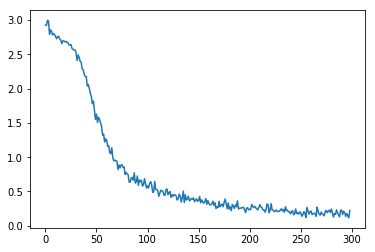

94.30962324142456  seconds have elapsed during training


In [8]:
try:
    t = time.time()
    ls = D.train(training_data_path, training_label_path,noise=mynoise, plot_step=250,fuzzify=0,use_data_subset=-1)
    plt.plot(ls)
    plt.show()
    elapsed = time.time() - t
    print(elapsed,' seconds have elapsed during training')
except:
    print('Some error occurred, probably test data file size exceeds maximum permitted size')

In [9]:
try:
    t = time.time()
    avg_loss, misclfd, total_num = D.test(test_data_path, test_label_path,noise=mynoise,use_data_subset=7000,fuzzify=0)
    print(avg_loss)
    print('Misclassified %d out of %d -> Loss of %.2f percent\n'%(misclfd,total_num,100*misclfd/total_num))
    elapsed = time.time() - t
    print(elapsed,' seconds have elapsed during testing')
except:
    print('Some error occurred, probably test data file size exceeds maximum permitted size')

Loading data...

(60000, 100)
(60000, 1)
Loaded 7000 data samples and corresponding labels

k=0: Avg loss so far = nan
     Misclassifications: 1

k=1: Avg loss so far = 4.000000
     Misclassifications: 1

k=2: Avg loss so far = 2.000000
     Misclassifications: 1

k=3: Avg loss so far = 1.333333
     Misclassifications: 1

k=4: Avg loss so far = 1.000000
     Misclassifications: 1

k=5: Avg loss so far = 0.800000
     Misclassifications: 1

k=6: Avg loss so far = 0.666667
     Misclassifications: 1

k=7: Avg loss so far = 0.571429
     Misclassifications: 1

k=8: Avg loss so far = 0.500000
     Misclassifications: 1

k=9: Avg loss so far = 0.444444
     Misclassifications: 1

k=10: Avg loss so far = 0.400000
     Misclassifications: 1

k=11: Avg loss so far = 0.363636
     Misclassifications: 1

k=12: Avg loss so far = 0.333333
     Misclassifications: 1

k=13: Avg loss so far = 0.307692
     Misclassifications: 1

k=14: Avg loss so far = 0.285714
     Misclassifications: 1

k=15: Av

c:\users\jan\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\jan\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k=130: Avg loss so far = 0.561538
     Misclassifications: 4

k=131: Avg loss so far = 0.557252
     Misclassifications: 4

k=132: Avg loss so far = 0.553030
     Misclassifications: 4

k=133: Avg loss so far = 0.548872
     Misclassifications: 4

k=134: Avg loss so far = 0.544776
     Misclassifications: 4

k=135: Avg loss so far = 0.540741
     Misclassifications: 4

k=136: Avg loss so far = 0.536765
     Misclassifications: 4

k=137: Avg loss so far = 0.532847
     Misclassifications: 4

k=138: Avg loss so far = 0.528986
     Misclassifications: 4

k=139: Avg loss so far = 0.525180
     Misclassifications: 4

k=140: Avg loss so far = 0.521429
     Misclassifications: 4

k=141: Avg loss so far = 0.517730
     Misclassifications: 4

k=142: Avg loss so far = 0.514085
     Misclassifications: 4

k=143: Avg loss so far = 0.510490
     Misclassifications: 4

k=144: Avg loss so far = 0.506944
     Misclassifications: 4

k=145: Avg loss so far = 0.503448
     Misclassifications: 4

k=146: A

k=315: Avg loss so far = 0.469841
     Misclassifications: 10

k=316: Avg loss so far = 0.468354
     Misclassifications: 11

k=317: Avg loss so far = 0.517350
     Misclassifications: 11

k=318: Avg loss so far = 0.515723
     Misclassifications: 11

k=319: Avg loss so far = 0.514107
     Misclassifications: 11

k=320: Avg loss so far = 0.512500
     Misclassifications: 11

k=321: Avg loss so far = 0.510903
     Misclassifications: 11

k=322: Avg loss so far = 0.509317
     Misclassifications: 11

k=323: Avg loss so far = 0.507740
     Misclassifications: 11

k=324: Avg loss so far = 0.506173
     Misclassifications: 11

k=325: Avg loss so far = 0.504615
     Misclassifications: 11

k=326: Avg loss so far = 0.503067
     Misclassifications: 11

k=327: Avg loss so far = 0.501529
     Misclassifications: 12

k=328: Avg loss so far = 0.548780
     Misclassifications: 12

k=329: Avg loss so far = 0.547112
     Misclassifications: 12

k=330: Avg loss so far = 0.545455
     Misclassificatio

k=554: Avg loss so far = 0.577617
     Misclassifications: 20

k=555: Avg loss so far = 0.576577
     Misclassifications: 20

k=556: Avg loss so far = 0.575540
     Misclassifications: 20

k=557: Avg loss so far = 0.574506
     Misclassifications: 20

k=558: Avg loss so far = 0.573477
     Misclassifications: 20

k=559: Avg loss so far = 0.572451
     Misclassifications: 20

k=560: Avg loss so far = 0.571429
     Misclassifications: 20

k=561: Avg loss so far = 0.570410
     Misclassifications: 20

k=562: Avg loss so far = 0.569395
     Misclassifications: 20

k=563: Avg loss so far = 0.568384
     Misclassifications: 20

k=564: Avg loss so far = 0.567376
     Misclassifications: 20

k=565: Avg loss so far = 0.566372
     Misclassifications: 20

k=566: Avg loss so far = 0.565371
     Misclassifications: 20

k=567: Avg loss so far = 0.564374
     Misclassifications: 20

k=568: Avg loss so far = 0.563380
     Misclassifications: 20

k=569: Avg loss so far = 0.562390
     Misclassificatio

k=795: Avg loss so far = 0.495597
     Misclassifications: 25

k=796: Avg loss so far = 0.494975
     Misclassifications: 25

k=797: Avg loss so far = 0.494354
     Misclassifications: 25

k=798: Avg loss so far = 0.493734
     Misclassifications: 26

k=799: Avg loss so far = 0.573217
     Misclassifications: 26

k=800: Avg loss so far = 0.572500
     Misclassifications: 26

k=801: Avg loss so far = 0.571785
     Misclassifications: 26

k=802: Avg loss so far = 0.571072
     Misclassifications: 26

k=803: Avg loss so far = 0.570361
     Misclassifications: 26

k=804: Avg loss so far = 0.569652
     Misclassifications: 26

k=805: Avg loss so far = 0.568944
     Misclassifications: 26

k=806: Avg loss so far = 0.568238
     Misclassifications: 26

k=807: Avg loss so far = 0.567534
     Misclassifications: 26

k=808: Avg loss so far = 0.566832
     Misclassifications: 26

k=809: Avg loss so far = 0.566131
     Misclassifications: 26

k=810: Avg loss so far = 0.565432
     Misclassificatio

k=1033: Avg loss so far = 0.890610
     Misclassifications: 38

k=1034: Avg loss so far = 0.889749
     Misclassifications: 38

k=1035: Avg loss so far = 0.888889
     Misclassifications: 38

k=1036: Avg loss so far = 0.888031
     Misclassifications: 38

k=1037: Avg loss so far = 0.887175
     Misclassifications: 38

k=1038: Avg loss so far = 0.886320
     Misclassifications: 38

k=1039: Avg loss so far = 0.885467
     Misclassifications: 38

k=1040: Avg loss so far = 0.884615
     Misclassifications: 38

k=1041: Avg loss so far = 0.883766
     Misclassifications: 38

k=1042: Avg loss so far = 0.882917
     Misclassifications: 38

k=1043: Avg loss so far = 0.882071
     Misclassifications: 38

k=1044: Avg loss so far = 0.881226
     Misclassifications: 38

k=1045: Avg loss so far = 0.880383
     Misclassifications: 38

k=1046: Avg loss so far = 0.879541
     Misclassifications: 38

k=1047: Avg loss so far = 0.878701
     Misclassifications: 38

k=1048: Avg loss so far = 0.877863
     

k=1269: Avg loss so far = 0.899921
     Misclassifications: 47

k=1270: Avg loss so far = 0.899213
     Misclassifications: 47

k=1271: Avg loss so far = 0.898505
     Misclassifications: 47

k=1272: Avg loss so far = 0.897799
     Misclassifications: 47

k=1273: Avg loss so far = 0.897093
     Misclassifications: 47

k=1274: Avg loss so far = 0.896389
     Misclassifications: 47

k=1275: Avg loss so far = 0.895686
     Misclassifications: 47

k=1276: Avg loss so far = 0.894984
     Misclassifications: 47

k=1277: Avg loss so far = 0.894283
     Misclassifications: 47

k=1278: Avg loss so far = 0.893584
     Misclassifications: 47

k=1279: Avg loss so far = 0.892885
     Misclassifications: 47

k=1280: Avg loss so far = 0.892188
     Misclassifications: 47

k=1281: Avg loss so far = 0.891491
     Misclassifications: 47

k=1282: Avg loss so far = 0.890796
     Misclassifications: 47

k=1283: Avg loss so far = 0.890101
     Misclassifications: 47

k=1284: Avg loss so far = 0.889408
     

k=1398: Avg loss so far = 1.121602
     Misclassifications: 56

k=1399: Avg loss so far = 1.120801
     Misclassifications: 56

k=1400: Avg loss so far = 1.120000
     Misclassifications: 56

k=1401: Avg loss so far = 1.119201
     Misclassifications: 56

k=1402: Avg loss so far = 1.118402
     Misclassifications: 56

k=1403: Avg loss so far = 1.117605
     Misclassifications: 56

k=1404: Avg loss so far = 1.116809
     Misclassifications: 56

k=1405: Avg loss so far = 1.116014
     Misclassifications: 56

k=1406: Avg loss so far = 1.115220
     Misclassifications: 56

k=1407: Avg loss so far = 1.114428
     Misclassifications: 56

k=1408: Avg loss so far = 1.113636
     Misclassifications: 56

k=1409: Avg loss so far = 1.112846
     Misclassifications: 56

k=1410: Avg loss so far = 1.112057
     Misclassifications: 56

k=1411: Avg loss so far = 1.111269
     Misclassifications: 56

k=1412: Avg loss so far = 1.110482
     Misclassifications: 56

k=1413: Avg loss so far = 1.109696
     

k=1627: Avg loss so far = 1.111862
     Misclassifications: 63

k=1628: Avg loss so far = 1.111179
     Misclassifications: 63

k=1629: Avg loss so far = 1.110497
     Misclassifications: 63

k=1630: Avg loss so far = 1.109816
     Misclassifications: 63

k=1631: Avg loss so far = 1.109135
     Misclassifications: 63

k=1632: Avg loss so far = 1.108456
     Misclassifications: 63

k=1633: Avg loss so far = 1.107777
     Misclassifications: 63

k=1634: Avg loss so far = 1.107099
     Misclassifications: 63

k=1635: Avg loss so far = 1.106422
     Misclassifications: 64

k=1636: Avg loss so far = 1.108191
     Misclassifications: 64

k=1637: Avg loss so far = 1.107514
     Misclassifications: 64

k=1638: Avg loss so far = 1.106838
     Misclassifications: 64

k=1639: Avg loss so far = 1.106162
     Misclassifications: 64

k=1640: Avg loss so far = 1.105488
     Misclassifications: 64

k=1641: Avg loss so far = 1.104814
     Misclassifications: 64

k=1642: Avg loss so far = 1.104141
     

k=1870: Avg loss so far = 1.090909
     Misclassifications: 75

k=1871: Avg loss so far = 1.090326
     Misclassifications: 75

k=1872: Avg loss so far = 1.089744
     Misclassifications: 75

k=1873: Avg loss so far = 1.089162
     Misclassifications: 75

k=1874: Avg loss so far = 1.088581
     Misclassifications: 75

k=1875: Avg loss so far = 1.088000
     Misclassifications: 75

k=1876: Avg loss so far = 1.087420
     Misclassifications: 75

k=1877: Avg loss so far = 1.086841
     Misclassifications: 75

k=1878: Avg loss so far = 1.086262
     Misclassifications: 75

k=1879: Avg loss so far = 1.085684
     Misclassifications: 75

k=1880: Avg loss so far = 1.085106
     Misclassifications: 75

k=1881: Avg loss so far = 1.084530
     Misclassifications: 75

k=1882: Avg loss so far = 1.083953
     Misclassifications: 75

k=1883: Avg loss so far = 1.083378
     Misclassifications: 75

k=1884: Avg loss so far = 1.082803
     Misclassifications: 75

k=1885: Avg loss so far = 1.082228
     

k=2114: Avg loss so far = 1.028855
     Misclassifications: 84

k=2115: Avg loss so far = 1.028369
     Misclassifications: 84

k=2116: Avg loss so far = 1.027883
     Misclassifications: 84

k=2117: Avg loss so far = 1.027397
     Misclassifications: 84

k=2118: Avg loss so far = 1.026912
     Misclassifications: 84

k=2119: Avg loss so far = 1.026428
     Misclassifications: 84

k=2120: Avg loss so far = 1.025943
     Misclassifications: 84

k=2121: Avg loss so far = 1.025460
     Misclassifications: 84

k=2122: Avg loss so far = 1.024976
     Misclassifications: 84

k=2123: Avg loss so far = 1.024494
     Misclassifications: 84

k=2124: Avg loss so far = 1.024011
     Misclassifications: 84

k=2125: Avg loss so far = 1.023529
     Misclassifications: 84

k=2126: Avg loss so far = 1.023048
     Misclassifications: 84

k=2127: Avg loss so far = 1.022567
     Misclassifications: 84

k=2128: Avg loss so far = 1.022086
     Misclassifications: 84

k=2129: Avg loss so far = 1.021606
     

k=2357: Avg loss so far = 1.012304
     Misclassifications: 94

k=2358: Avg loss so far = 1.011874
     Misclassifications: 94

k=2359: Avg loss so far = 1.011446
     Misclassifications: 94

k=2360: Avg loss so far = 1.011017
     Misclassifications: 94

k=2361: Avg loss so far = 1.010589
     Misclassifications: 94

k=2362: Avg loss so far = 1.010161
     Misclassifications: 94

k=2363: Avg loss so far = 1.009733
     Misclassifications: 94

k=2364: Avg loss so far = 1.009306
     Misclassifications: 94

k=2365: Avg loss so far = 1.008879
     Misclassifications: 94

k=2366: Avg loss so far = 1.008453
     Misclassifications: 94

k=2367: Avg loss so far = 1.008027
     Misclassifications: 94

k=2368: Avg loss so far = 1.007601
     Misclassifications: 94

k=2369: Avg loss so far = 1.007176
     Misclassifications: 94

k=2370: Avg loss so far = 1.006751
     Misclassifications: 94

k=2371: Avg loss so far = 1.006326
     Misclassifications: 94

k=2372: Avg loss so far = 1.005902
     

k=2594: Avg loss so far = 1.108327
     Misclassifications: 109

k=2595: Avg loss so far = 1.107900
     Misclassifications: 109

k=2596: Avg loss so far = 1.107473
     Misclassifications: 109

k=2597: Avg loss so far = 1.107047
     Misclassifications: 109

k=2598: Avg loss so far = 1.106620
     Misclassifications: 109

k=2599: Avg loss so far = 1.106195
     Misclassifications: 109

k=2600: Avg loss so far = 1.105769
     Misclassifications: 109

k=2601: Avg loss so far = 1.105344
     Misclassifications: 109

k=2602: Avg loss so far = 1.104919
     Misclassifications: 109

k=2603: Avg loss so far = 1.104495
     Misclassifications: 109

k=2604: Avg loss so far = 1.104071
     Misclassifications: 109

k=2605: Avg loss so far = 1.103647
     Misclassifications: 109

k=2606: Avg loss so far = 1.103223
     Misclassifications: 109

k=2607: Avg loss so far = 1.102800
     Misclassifications: 109

k=2608: Avg loss so far = 1.102377
     Misclassifications: 109

k=2609: Avg loss so far =

k=2725: Avg loss so far = 1.059450
     Misclassifications: 112

k=2726: Avg loss so far = 1.059061
     Misclassifications: 112

k=2727: Avg loss so far = 1.058673
     Misclassifications: 112

k=2728: Avg loss so far = 1.058284
     Misclassifications: 112

k=2729: Avg loss so far = 1.057897
     Misclassifications: 112

k=2730: Avg loss so far = 1.057509
     Misclassifications: 112

k=2731: Avg loss so far = 1.057122
     Misclassifications: 112

k=2732: Avg loss so far = 1.056735
     Misclassifications: 112

k=2733: Avg loss so far = 1.056348
     Misclassifications: 112

k=2734: Avg loss so far = 1.055962
     Misclassifications: 112

k=2735: Avg loss so far = 1.055576
     Misclassifications: 112

k=2736: Avg loss so far = 1.055190
     Misclassifications: 112

k=2737: Avg loss so far = 1.054805
     Misclassifications: 112

k=2738: Avg loss so far = 1.054419
     Misclassifications: 112

k=2739: Avg loss so far = 1.054034
     Misclassifications: 112

k=2740: Avg loss so far =

k=2970: Avg loss so far = 1.024916
     Misclassifications: 122

k=2971: Avg loss so far = 1.024571
     Misclassifications: 122

k=2972: Avg loss so far = 1.024226
     Misclassifications: 122

k=2973: Avg loss so far = 1.023882
     Misclassifications: 122

k=2974: Avg loss so far = 1.023537
     Misclassifications: 122

k=2975: Avg loss so far = 1.023193
     Misclassifications: 122

k=2976: Avg loss so far = 1.022849
     Misclassifications: 122

k=2977: Avg loss so far = 1.022506
     Misclassifications: 122

k=2978: Avg loss so far = 1.022163
     Misclassifications: 122

k=2979: Avg loss so far = 1.021819
     Misclassifications: 122

k=2980: Avg loss so far = 1.021477
     Misclassifications: 122

k=2981: Avg loss so far = 1.021134
     Misclassifications: 122

k=2982: Avg loss so far = 1.020791
     Misclassifications: 122

k=2983: Avg loss so far = 1.020449
     Misclassifications: 122

k=2984: Avg loss so far = 1.020107
     Misclassifications: 122

k=2985: Avg loss so far =

k=3211: Avg loss so far = 0.991280
     Misclassifications: 129

k=3212: Avg loss so far = 0.990971
     Misclassifications: 129

k=3213: Avg loss so far = 0.990663
     Misclassifications: 129

k=3214: Avg loss so far = 0.990355
     Misclassifications: 129

k=3215: Avg loss so far = 0.990047
     Misclassifications: 129

k=3216: Avg loss so far = 0.989739
     Misclassifications: 129

k=3217: Avg loss so far = 0.989431
     Misclassifications: 129

k=3218: Avg loss so far = 0.989124
     Misclassifications: 130

k=3219: Avg loss so far = 0.989127
     Misclassifications: 131

k=3220: Avg loss so far = 0.989130
     Misclassifications: 131

k=3221: Avg loss so far = 0.988823
     Misclassifications: 131

k=3222: Avg loss so far = 0.988516
     Misclassifications: 131

k=3223: Avg loss so far = 0.988210
     Misclassifications: 131

k=3224: Avg loss so far = 0.987903
     Misclassifications: 131

k=3225: Avg loss so far = 0.987597
     Misclassifications: 131

k=3226: Avg loss so far =

k=3339: Avg loss so far = 0.960168
     Misclassifications: 134

k=3340: Avg loss so far = 0.959880
     Misclassifications: 134

k=3341: Avg loss so far = 0.959593
     Misclassifications: 134

k=3342: Avg loss so far = 0.959306
     Misclassifications: 134

k=3343: Avg loss so far = 0.959019
     Misclassifications: 134

k=3344: Avg loss so far = 0.958732
     Misclassifications: 134

k=3345: Avg loss so far = 0.958445
     Misclassifications: 134

k=3346: Avg loss so far = 0.958159
     Misclassifications: 134

k=3347: Avg loss so far = 0.957873
     Misclassifications: 134

k=3348: Avg loss so far = 0.957587
     Misclassifications: 134

k=3349: Avg loss so far = 0.957301
     Misclassifications: 134

k=3350: Avg loss so far = 0.957015
     Misclassifications: 134

k=3351: Avg loss so far = 0.956729
     Misclassifications: 134

k=3352: Avg loss so far = 0.956444
     Misclassifications: 134

k=3353: Avg loss so far = 0.956159
     Misclassifications: 134

k=3354: Avg loss so far =

k=3583: Avg loss so far = 1.008094
     Misclassifications: 147

k=3584: Avg loss so far = 1.007812
     Misclassifications: 147

k=3585: Avg loss so far = 1.007531
     Misclassifications: 147

k=3586: Avg loss so far = 1.007250
     Misclassifications: 147

k=3587: Avg loss so far = 1.006970
     Misclassifications: 147

k=3588: Avg loss so far = 1.006689
     Misclassifications: 147

k=3589: Avg loss so far = 1.006408
     Misclassifications: 147

k=3590: Avg loss so far = 1.006128
     Misclassifications: 147

k=3591: Avg loss so far = 1.005848
     Misclassifications: 147

k=3592: Avg loss so far = 1.005568
     Misclassifications: 147

k=3593: Avg loss so far = 1.005288
     Misclassifications: 147

k=3594: Avg loss so far = 1.005008
     Misclassifications: 147

k=3595: Avg loss so far = 1.004729
     Misclassifications: 147

k=3596: Avg loss so far = 1.004449
     Misclassifications: 147

k=3597: Avg loss so far = 1.004170
     Misclassifications: 147

k=3598: Avg loss so far =

k=3824: Avg loss so far = 1.068253
     Misclassifications: 163

k=3825: Avg loss so far = 1.067974
     Misclassifications: 163

k=3826: Avg loss so far = 1.067695
     Misclassifications: 163

k=3827: Avg loss so far = 1.067416
     Misclassifications: 164

k=3828: Avg loss so far = 1.083856
     Misclassifications: 164

k=3829: Avg loss so far = 1.083573
     Misclassifications: 164

k=3830: Avg loss so far = 1.083290
     Misclassifications: 164

k=3831: Avg loss so far = 1.083007
     Misclassifications: 164

k=3832: Avg loss so far = 1.082724
     Misclassifications: 164

k=3833: Avg loss so far = 1.082442
     Misclassifications: 164

k=3834: Avg loss so far = 1.082160
     Misclassifications: 164

k=3835: Avg loss so far = 1.081877
     Misclassifications: 164

k=3836: Avg loss so far = 1.081595
     Misclassifications: 164

k=3837: Avg loss so far = 1.081314
     Misclassifications: 164

k=3838: Avg loss so far = 1.081032
     Misclassifications: 164

k=3839: Avg loss so far =

k=3954: Avg loss so far = 1.071826
     Misclassifications: 169

k=3955: Avg loss so far = 1.071555
     Misclassifications: 170

k=3956: Avg loss so far = 1.091759
     Misclassifications: 170

k=3957: Avg loss so far = 1.091483
     Misclassifications: 170

k=3958: Avg loss so far = 1.091208
     Misclassifications: 170

k=3959: Avg loss so far = 1.090932
     Misclassifications: 170

k=3960: Avg loss so far = 1.090657
     Misclassifications: 170

k=3961: Avg loss so far = 1.090381
     Misclassifications: 170

k=3962: Avg loss so far = 1.090106
     Misclassifications: 170

k=3963: Avg loss so far = 1.089831
     Misclassifications: 170

k=3964: Avg loss so far = 1.089556
     Misclassifications: 170

k=3965: Avg loss so far = 1.089281
     Misclassifications: 170

k=3966: Avg loss so far = 1.089007
     Misclassifications: 170

k=3967: Avg loss so far = 1.088732
     Misclassifications: 170

k=3968: Avg loss so far = 1.088458
     Misclassifications: 170

k=3969: Avg loss so far =

k=4186: Avg loss so far = 1.121835
     Misclassifications: 181

k=4187: Avg loss so far = 1.121567
     Misclassifications: 181

k=4188: Avg loss so far = 1.121299
     Misclassifications: 181

k=4189: Avg loss so far = 1.121031
     Misclassifications: 181

k=4190: Avg loss so far = 1.120764
     Misclassifications: 181

k=4191: Avg loss so far = 1.120496
     Misclassifications: 181

k=4192: Avg loss so far = 1.120229
     Misclassifications: 181

k=4193: Avg loss so far = 1.119962
     Misclassifications: 181

k=4194: Avg loss so far = 1.119695
     Misclassifications: 181

k=4195: Avg loss so far = 1.119428
     Misclassifications: 181

k=4196: Avg loss so far = 1.119161
     Misclassifications: 181

k=4197: Avg loss so far = 1.118894
     Misclassifications: 181

k=4198: Avg loss so far = 1.118628
     Misclassifications: 181

k=4199: Avg loss so far = 1.118362
     Misclassifications: 181

k=4200: Avg loss so far = 1.118095
     Misclassifications: 181

k=4201: Avg loss so far =

k=4318: Avg loss so far = 1.089162
     Misclassifications: 185

k=4319: Avg loss so far = 1.088909
     Misclassifications: 185

k=4320: Avg loss so far = 1.088657
     Misclassifications: 185

k=4321: Avg loss so far = 1.088405
     Misclassifications: 185

k=4322: Avg loss so far = 1.088154
     Misclassifications: 185

k=4323: Avg loss so far = 1.087902
     Misclassifications: 185

k=4324: Avg loss so far = 1.087650
     Misclassifications: 185

k=4325: Avg loss so far = 1.087399
     Misclassifications: 185

k=4326: Avg loss so far = 1.087147
     Misclassifications: 185

k=4327: Avg loss so far = 1.086896
     Misclassifications: 185

k=4328: Avg loss so far = 1.086645
     Misclassifications: 185

k=4329: Avg loss so far = 1.086394
     Misclassifications: 185

k=4330: Avg loss so far = 1.086143
     Misclassifications: 185

k=4331: Avg loss so far = 1.085892
     Misclassifications: 185

k=4332: Avg loss so far = 1.085642
     Misclassifications: 185

k=4333: Avg loss so far =

k=4564: Avg loss so far = 1.127082
     Misclassifications: 194

k=4565: Avg loss so far = 1.126835
     Misclassifications: 194

k=4566: Avg loss so far = 1.126588
     Misclassifications: 194

k=4567: Avg loss so far = 1.126341
     Misclassifications: 194

k=4568: Avg loss so far = 1.126095
     Misclassifications: 195

k=4569: Avg loss so far = 1.126724
     Misclassifications: 195

k=4570: Avg loss so far = 1.126477
     Misclassifications: 195

k=4571: Avg loss so far = 1.126231
     Misclassifications: 195

k=4572: Avg loss so far = 1.125984
     Misclassifications: 195

k=4573: Avg loss so far = 1.125738
     Misclassifications: 195

k=4574: Avg loss so far = 1.125492
     Misclassifications: 195

k=4575: Avg loss so far = 1.125246
     Misclassifications: 195

k=4576: Avg loss so far = 1.125000
     Misclassifications: 195

k=4577: Avg loss so far = 1.124754
     Misclassifications: 195

k=4578: Avg loss so far = 1.124509
     Misclassifications: 195

k=4579: Avg loss so far =

k=4805: Avg loss so far = 1.115713
     Misclassifications: 204

k=4806: Avg loss so far = 1.115481
     Misclassifications: 204

k=4807: Avg loss so far = 1.115249
     Misclassifications: 204

k=4808: Avg loss so far = 1.115017
     Misclassifications: 204

k=4809: Avg loss so far = 1.114785
     Misclassifications: 204

k=4810: Avg loss so far = 1.114553
     Misclassifications: 204

k=4811: Avg loss so far = 1.114321
     Misclassifications: 204

k=4812: Avg loss so far = 1.114090
     Misclassifications: 204

k=4813: Avg loss so far = 1.113858
     Misclassifications: 204

k=4814: Avg loss so far = 1.113627
     Misclassifications: 204

k=4815: Avg loss so far = 1.113396
     Misclassifications: 204

k=4816: Avg loss so far = 1.113164
     Misclassifications: 204

k=4817: Avg loss so far = 1.112933
     Misclassifications: 204

k=4818: Avg loss so far = 1.112702
     Misclassifications: 204

k=4819: Avg loss so far = 1.112471
     Misclassifications: 204

k=4820: Avg loss so far =

k=4936: Avg loss so far = 1.161467
     Misclassifications: 210

k=4937: Avg loss so far = 1.161232
     Misclassifications: 210

k=4938: Avg loss so far = 1.160996
     Misclassifications: 210

k=4939: Avg loss so far = 1.160761
     Misclassifications: 210

k=4940: Avg loss so far = 1.160526
     Misclassifications: 210

k=4941: Avg loss so far = 1.160291
     Misclassifications: 210

k=4942: Avg loss so far = 1.160057
     Misclassifications: 210

k=4943: Avg loss so far = 1.159822
     Misclassifications: 210

k=4944: Avg loss so far = 1.159587
     Misclassifications: 210

k=4945: Avg loss so far = 1.159353
     Misclassifications: 210

k=4946: Avg loss so far = 1.159118
     Misclassifications: 210

k=4947: Avg loss so far = 1.158884
     Misclassifications: 210

k=4948: Avg loss so far = 1.158650
     Misclassifications: 210

k=4949: Avg loss so far = 1.158416
     Misclassifications: 210

k=4950: Avg loss so far = 1.158182
     Misclassifications: 210

k=4951: Avg loss so far =

k=5177: Avg loss so far = 1.185436
     Misclassifications: 224

k=5178: Avg loss so far = 1.185207
     Misclassifications: 224

k=5179: Avg loss so far = 1.184978
     Misclassifications: 224

k=5180: Avg loss so far = 1.184749
     Misclassifications: 224

k=5181: Avg loss so far = 1.184520
     Misclassifications: 224

k=5182: Avg loss so far = 1.184292
     Misclassifications: 224

k=5183: Avg loss so far = 1.184063
     Misclassifications: 224

k=5184: Avg loss so far = 1.183835
     Misclassifications: 224

k=5185: Avg loss so far = 1.183607
     Misclassifications: 224

k=5186: Avg loss so far = 1.183378
     Misclassifications: 224

k=5187: Avg loss so far = 1.183150
     Misclassifications: 224

k=5188: Avg loss so far = 1.182922
     Misclassifications: 224

k=5189: Avg loss so far = 1.182694
     Misclassifications: 225

k=5190: Avg loss so far = 1.194798
     Misclassifications: 225

k=5191: Avg loss so far = 1.194568
     Misclassifications: 225

k=5192: Avg loss so far =

k=5421: Avg loss so far = 1.188895
     Misclassifications: 235

k=5422: Avg loss so far = 1.188676
     Misclassifications: 235

k=5423: Avg loss so far = 1.188457
     Misclassifications: 235

k=5424: Avg loss so far = 1.188237
     Misclassifications: 235

k=5425: Avg loss so far = 1.188018
     Misclassifications: 235

k=5426: Avg loss so far = 1.187799
     Misclassifications: 235

k=5427: Avg loss so far = 1.187581
     Misclassifications: 235

k=5428: Avg loss so far = 1.187362
     Misclassifications: 235

k=5429: Avg loss so far = 1.187143
     Misclassifications: 235

k=5430: Avg loss so far = 1.186924
     Misclassifications: 235

k=5431: Avg loss so far = 1.186706
     Misclassifications: 235

k=5432: Avg loss so far = 1.186487
     Misclassifications: 235

k=5433: Avg loss so far = 1.186269
     Misclassifications: 235

k=5434: Avg loss so far = 1.186051
     Misclassifications: 235

k=5435: Avg loss so far = 1.185833
     Misclassifications: 235

k=5436: Avg loss so far =

k=5666: Avg loss so far = 1.190434
     Misclassifications: 241

k=5667: Avg loss so far = 1.190224
     Misclassifications: 241

k=5668: Avg loss so far = 1.190014
     Misclassifications: 241

k=5669: Avg loss so far = 1.189804
     Misclassifications: 241

k=5670: Avg loss so far = 1.189594
     Misclassifications: 241

k=5671: Avg loss so far = 1.189385
     Misclassifications: 241

k=5672: Avg loss so far = 1.189175
     Misclassifications: 241

k=5673: Avg loss so far = 1.188965
     Misclassifications: 241

k=5674: Avg loss so far = 1.188756
     Misclassifications: 241

k=5675: Avg loss so far = 1.188546
     Misclassifications: 241

k=5676: Avg loss so far = 1.188337
     Misclassifications: 241

k=5677: Avg loss so far = 1.188128
     Misclassifications: 241

k=5678: Avg loss so far = 1.187918
     Misclassifications: 241

k=5679: Avg loss so far = 1.187709
     Misclassifications: 241

k=5680: Avg loss so far = 1.187500
     Misclassifications: 241

k=5681: Avg loss so far =

k=5911: Avg loss so far = 1.186601
     Misclassifications: 252

k=5912: Avg loss so far = 1.186401
     Misclassifications: 252

k=5913: Avg loss so far = 1.186200
     Misclassifications: 252

k=5914: Avg loss so far = 1.185999
     Misclassifications: 252

k=5915: Avg loss so far = 1.185799
     Misclassifications: 252

k=5916: Avg loss so far = 1.185598
     Misclassifications: 252

k=5917: Avg loss so far = 1.185398
     Misclassifications: 252

k=5918: Avg loss so far = 1.185198
     Misclassifications: 252

k=5919: Avg loss so far = 1.184997
     Misclassifications: 252

k=5920: Avg loss so far = 1.184797
     Misclassifications: 252

k=5921: Avg loss so far = 1.184597
     Misclassifications: 252

k=5922: Avg loss so far = 1.184397
     Misclassifications: 252

k=5923: Avg loss so far = 1.184197
     Misclassifications: 252

k=5924: Avg loss so far = 1.183997
     Misclassifications: 252

k=5925: Avg loss so far = 1.183797
     Misclassifications: 252

k=5926: Avg loss so far =

k=6155: Avg loss so far = 1.174817
     Misclassifications: 259

k=6156: Avg loss so far = 1.174626
     Misclassifications: 259

k=6157: Avg loss so far = 1.174436
     Misclassifications: 259

k=6158: Avg loss so far = 1.174245
     Misclassifications: 260

k=6159: Avg loss so far = 1.174217
     Misclassifications: 260

k=6160: Avg loss so far = 1.174026
     Misclassifications: 260

k=6161: Avg loss so far = 1.173835
     Misclassifications: 260

k=6162: Avg loss so far = 1.173645
     Misclassifications: 260

k=6163: Avg loss so far = 1.173454
     Misclassifications: 260

k=6164: Avg loss so far = 1.173264
     Misclassifications: 260

k=6165: Avg loss so far = 1.173074
     Misclassifications: 260

k=6166: Avg loss so far = 1.172884
     Misclassifications: 260

k=6167: Avg loss so far = 1.172693
     Misclassifications: 261

k=6168: Avg loss so far = 1.173152
     Misclassifications: 261

k=6169: Avg loss so far = 1.172962
     Misclassifications: 261

k=6170: Avg loss so far =

k=6390: Avg loss so far = 1.153365
     Misclassifications: 266

k=6391: Avg loss so far = 1.153184
     Misclassifications: 266

k=6392: Avg loss so far = 1.153004
     Misclassifications: 266

k=6393: Avg loss so far = 1.152823
     Misclassifications: 267

k=6394: Avg loss so far = 1.152799
     Misclassifications: 267

k=6395: Avg loss so far = 1.152619
     Misclassifications: 267

k=6396: Avg loss so far = 1.152439
     Misclassifications: 267

k=6397: Avg loss so far = 1.152259
     Misclassifications: 267

k=6398: Avg loss so far = 1.152079
     Misclassifications: 267

k=6399: Avg loss so far = 1.151899
     Misclassifications: 267

k=6400: Avg loss so far = 1.151719
     Misclassifications: 268

k=6401: Avg loss so far = 1.151695
     Misclassifications: 268

k=6402: Avg loss so far = 1.151515
     Misclassifications: 268

k=6403: Avg loss so far = 1.151335
     Misclassifications: 268

k=6404: Avg loss so far = 1.151156
     Misclassifications: 268

k=6405: Avg loss so far =

k=6611: Avg loss so far = 1.143549
     Misclassifications: 276

k=6612: Avg loss so far = 1.143376
     Misclassifications: 276

k=6613: Avg loss so far = 1.143203
     Misclassifications: 276

k=6614: Avg loss so far = 1.143030
     Misclassifications: 276

k=6615: Avg loss so far = 1.142857
     Misclassifications: 276

k=6616: Avg loss so far = 1.142684
     Misclassifications: 276

k=6617: Avg loss so far = 1.142512
     Misclassifications: 276

k=6618: Avg loss so far = 1.142339
     Misclassifications: 276

k=6619: Avg loss so far = 1.142166
     Misclassifications: 276

k=6620: Avg loss so far = 1.141994
     Misclassifications: 276

k=6621: Avg loss so far = 1.141821
     Misclassifications: 277

k=6622: Avg loss so far = 1.144065
     Misclassifications: 277

k=6623: Avg loss so far = 1.143892
     Misclassifications: 277

k=6624: Avg loss so far = 1.143720
     Misclassifications: 277

k=6625: Avg loss so far = 1.143547
     Misclassifications: 277

k=6626: Avg loss so far =


k=6856: Avg loss so far = 1.138565
     Misclassifications: 285

k=6857: Avg loss so far = 1.138399
     Misclassifications: 285

k=6858: Avg loss so far = 1.138233
     Misclassifications: 285

k=6859: Avg loss so far = 1.138067
     Misclassifications: 285

k=6860: Avg loss so far = 1.137901
     Misclassifications: 285

k=6861: Avg loss so far = 1.137735
     Misclassifications: 285

k=6862: Avg loss so far = 1.137569
     Misclassifications: 285

k=6863: Avg loss so far = 1.137403
     Misclassifications: 285

k=6864: Avg loss so far = 1.137238
     Misclassifications: 285

k=6865: Avg loss so far = 1.137072
     Misclassifications: 285

k=6866: Avg loss so far = 1.136906
     Misclassifications: 285

k=6867: Avg loss so far = 1.136741
     Misclassifications: 285

k=6868: Avg loss so far = 1.136575
     Misclassifications: 285

k=6869: Avg loss so far = 1.136410
     Misclassifications: 285

k=6870: Avg loss so far = 1.136245
     Misclassifications: 285

k=6871: Avg loss so far 

Bit error rate: 0.09850



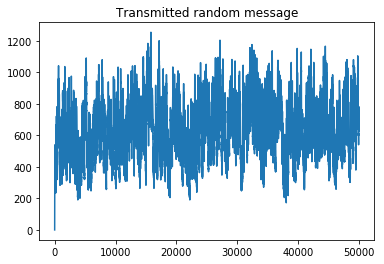

In [10]:
Tbit = 0.003
bits_per_slot = 4

decoded = D.decode_binary('test_message.csv',Tbit,bits_per_slot)
original = D.raw_datatable_load('test_message_bin.csv')
srec = D.raw_datatable_load('test_message.csv')

diff = decoded - original 
BER = float(len(diff[diff!=0])/original.shape[1])

print("Bit error rate: %.5f\n"%(BER))
plt.plot(srec[1,:])
plt.title('Transmitted random message')
plt.show()

In [11]:
print(np.sum(diff[0,:]!=0))

197


In [22]:
print(D.save())

decoder_model\DECODER_090.ckpt


***

### Progress
-  _MATLAB_ framework to generate and store training and test data according to one parameter set, and later test cases with the same parameters
-  _DECODER_ in Python plus functionality to automatically disasseble any received message from _MATLAB_ framework into slots and decode
-  Set parameters in _MATLAB_, train and test _DECODER_, then enter arbitrary string in _MATLAB_, generate the corresponding received sequence, and fully decode within python _DECODER_, to output original string
-  __Currently__: The framework is there, but  $BER\approx 4\%$  is insufficient to reliably transmit text, so I'm working on improving that by tweaking the _DECODER_ neural network a bit

***

### Issues
-  Having some trouble with arbitrary received data  $\Rightarrow$ **SOLVED**
    -  Subsequent slots aren't always of _DECODER_ required input length
    -  <del>Hence my solution: Resample data</del>
    -  <del>But this changes some of the features which _DECODER_ uses for classification (apparently)</del>
    -  Was an issue with the _MATLAB_ script used to generate data, fixed it
-  In-between slots, channel needs a certain cooldown period or else detection is less reliable  $\Rightarrow$ **SOLVED**
    -  I.e. _DECODER_ deals well with interference within one slot, but not in-between slots
    -  This is mainly because slot interference is not factored into the training process at this point

***

### My planned solution
-  [x] Incorporate resampling into the training process
-  [x] Incorporate slot-to-slot interference into the training process
-  <del>[ ] Increase number of bits per slot which can be decoded at once (Four and five bits per slot work, after that training process takes a lot more data)</del>

***

***
### TODO
-  [x]  Plot BER over different NN architectures
-  [x]  Plot BER over different training data corpus sizes
-  [ ]  Build a gradually more complex scenario and show effect on BER
    -  Network size can vary
    -  Training data corpus size can vary
    -  Randomness may vary
    -  $T_{\text{bit}}$ may vary
-  [ ]  For each scenario, construct a pseudo-optimal neural network for the _DECODER_
-  [ ]  Try with Harald data
-  [x]  Increase number of bits per slot which can be decoded at once -> Works, but requires more layers and accordingly, longer training times. Had to add one layer for 4-bit slots
***

In [12]:
DATA, LABELS = D.load_data_and_labels(manualtrial_data_path,manualtrial_label_path,noise=mynoise)
DATA,_ = D.norm_data(DATA,[0,1])

(60000, 100)
(60000, 1)


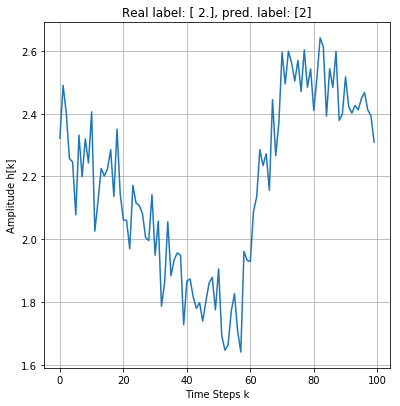

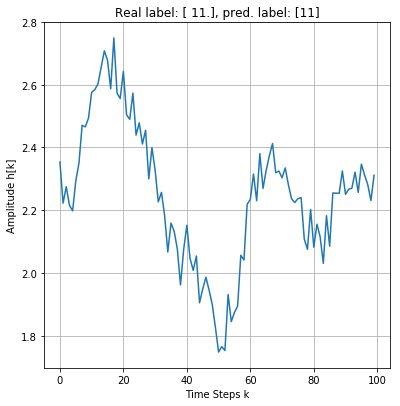

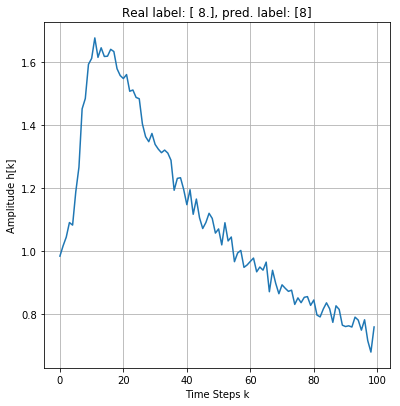

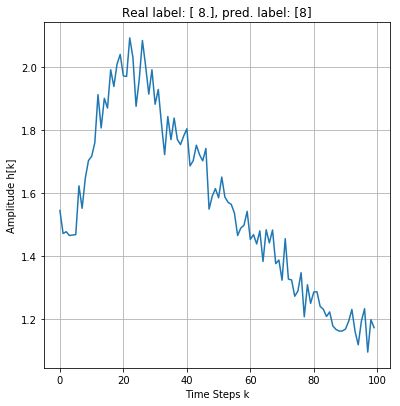

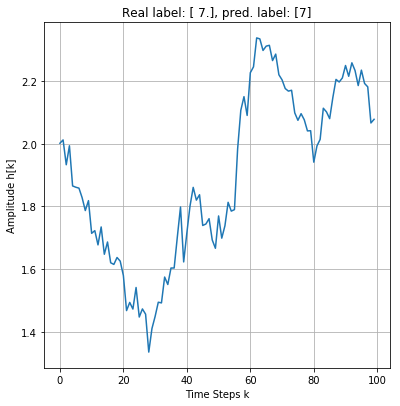

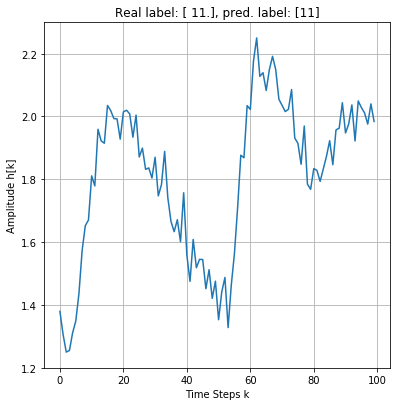

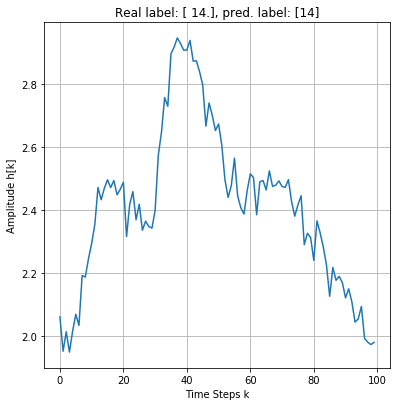

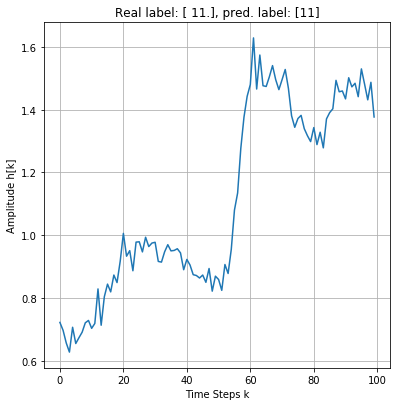

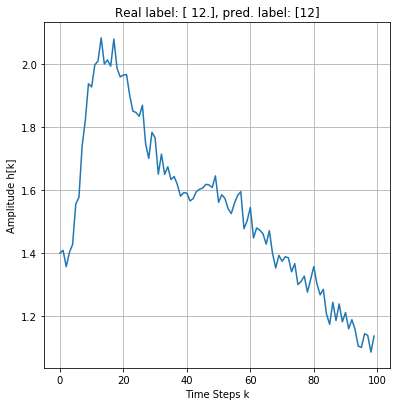

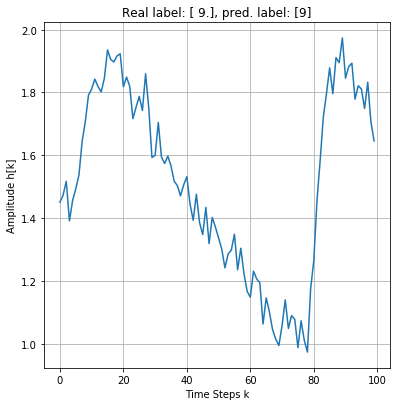

In [22]:
#I = rnd.randint(0,DATA.shape[0],10)

for ind in I:
    td = DATA[ind,:]+0*rnd.randn(DATA.shape[1])
    tl = LABELS[ind,:]
    class_sugg, pred_struct = D.decode(td)
    
    plt.figure(ind, figsize=(6, 6))
    ax = plt.axes([0.1, 0.1, 0.8, 0.8])
    
    plt.plot(td)
    plt.title('Real label: '+str(tl)+', pred. label: '+str(class_sugg))
    plt.grid()
    plt.xlabel('Time Steps k')
    plt.ylabel('Amplitude h[k]')
    #plt.show()
    
    savestr = 'plot_dec_data_'+str(ind)+'.png'
    plt.savefig(savestr)